In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence
from xgboost import XGBRegressor

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Data Preprocessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/큐슈제강_조업데이터시트_2024년_전체합본.csv', low_memory=False)

# Check and remove rows with missing (NaN) values
missing_count = df.isnull().sum().sum()

if missing_count > 0:
    # Determine threshold: must have at least half of the columns NOT NaN, drop rows where they aren't
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2679


In [3]:
# Create datasets
variable_1 = '버너O2_주요장입'
variable_2 = '란스O2_주요장입'
variable_3 = '취부회수'
variable_4 = '연회회수'

# Convert to numeric, drop rows that couldn't be converted (20240101-1)
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])

# Removes SC410 entries
lower_bound = 9000
upper_bound = 500000000

# Apply filter
df = df[df['강번'].between(9000, 500000000)]

# Bounds
if variable_1 in df.columns:
    initial_count_oxygen = len(df)
    df = df[df[variable_1] >= 10]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where '{variable_1}' < 10.")
else:
    print(f"Warning: '{variable_1}' column not found.")

# For double checking
df.to_csv('For_my_use_1.csv', index=False)

Removed 2 rows where '버너O2_주요장입' < 10.


In [4]:
X = df[[variable_1, variable_2, variable_3, variable_4]]  # include more predictors as needed
y = df['유효전력량_주장']

# Determine split index
split_index = int(len(X) * 0.7)

# Sequential split (first 70% for training, last 30% for testing)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# MLR

In [5]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


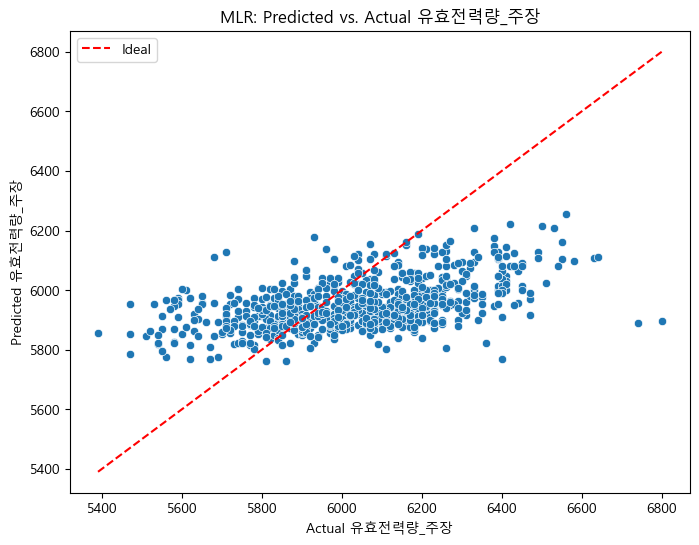


--- Model Evaluation ---
Mean Squared Error: 44565.85591947709
RMSE: 211.10626688821225
R² Score: 0.08302386536334583

Intercept: -2910.8060673854616
Coefficients:
  버너O2_주요장입: 31.26403620202668
  란스O2_주요장입: 4.792713664595832
  취부회수: -10.669663250376349
  연회회수: -0.4937155168831766


In [6]:
y_pred = model.predict(X_test)

# Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual 유효전력량_주장')
plt.ylabel('Predicted 유효전력량_주장')
plt.title('MLR: Predicted vs. Actual 유효전력량_주장')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.legend()

plt.show()

MSE = mean_squared_error(y_test, y_pred)

# Evaluation metrics
print("\n--- Model Evaluation ---")
print("Mean Squared Error:", MSE)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)
print("R² Score:", r2_score(y_test, y_pred))
print("\nIntercept:", model.intercept_)
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"  {feature}: {coef}")

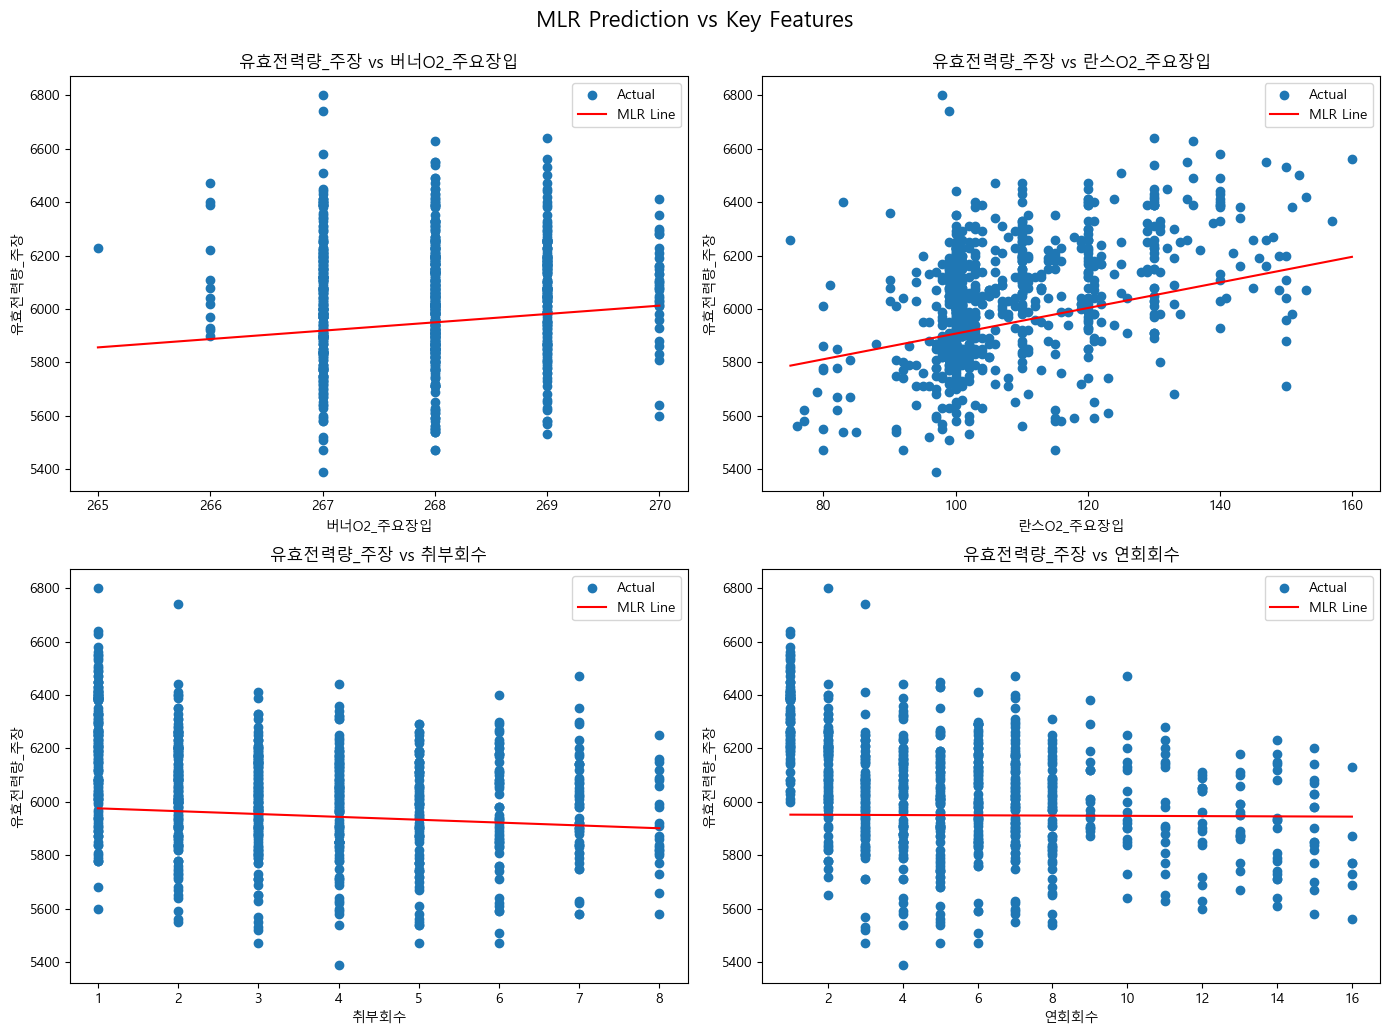

In [7]:
variables = [variable_1, variable_2, variable_3, variable_4]  # Update as you go

feature_means = X_test.mean()

# Subplots
n_vars = len(variables)
cols = 2
rows = math.ceil(n_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Generate plots
for i, var in enumerate(variables):
    ax = axes[i]
    x_vals = np.linspace(X_test[var].min(), X_test[var].max(), 100)
    y_vals = np.full_like(x_vals, model.intercept_, dtype=float)
    for j, col in enumerate(X_test.columns):
        if col == var:
            y_vals += model.coef_[j] * x_vals  # vary only current variable
        else:
            y_vals += model.coef_[j] * feature_means[col]  # fix others at mean

    # Scatter actual vs predicted
    ax.scatter(X_test[var], y_test, alpha=1, label='Actual')
    ax.plot(x_vals, y_vals, color='red', label='MLR Line')
    ax.set_xlabel(var)
    ax.set_ylabel('유효전력량_주장')
    ax.set_title(f'유효전력량_주장 vs {var}')
    ax.legend()

# Remove any unused axes (if total axes > variable count)
for j in range(n_vars, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('MLR Prediction vs Key Features', fontsize=16, y=1.03)
plt.show()

# XGBoost

In [8]:
# XGBoost Model set up
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth= 4,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

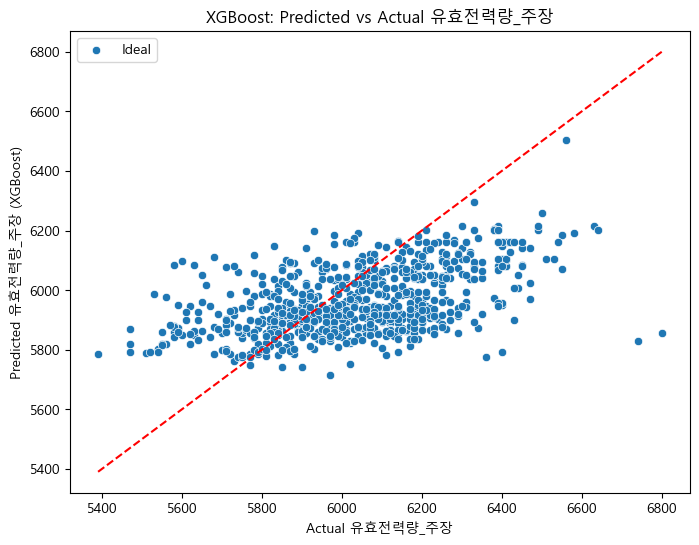


--- XGBoost Model Evaluation ---
Mean Squared Error: 41680.5078125
XGBoost RMSE: 204.15804616154614
R² Score: 0.142392098903656


In [9]:
# XGBoost Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=xgb_pred)
plt.xlabel('Actual 유효전력량_주장')
plt.ylabel('Predicted 유효전력량_주장 (XGBoost)')
plt.title('XGBoost: Predicted vs Actual 유효전력량_주장')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.legend(['Ideal'])
plt.show()

# Evaluation
print("\n--- XGBoost Model Evaluation ---")
print("Mean Squared Error:", mean_squared_error(y_test, xgb_pred))
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("XGBoost RMSE:", rmse_xgb)
print("R² Score:", r2_score(y_test, xgb_pred))

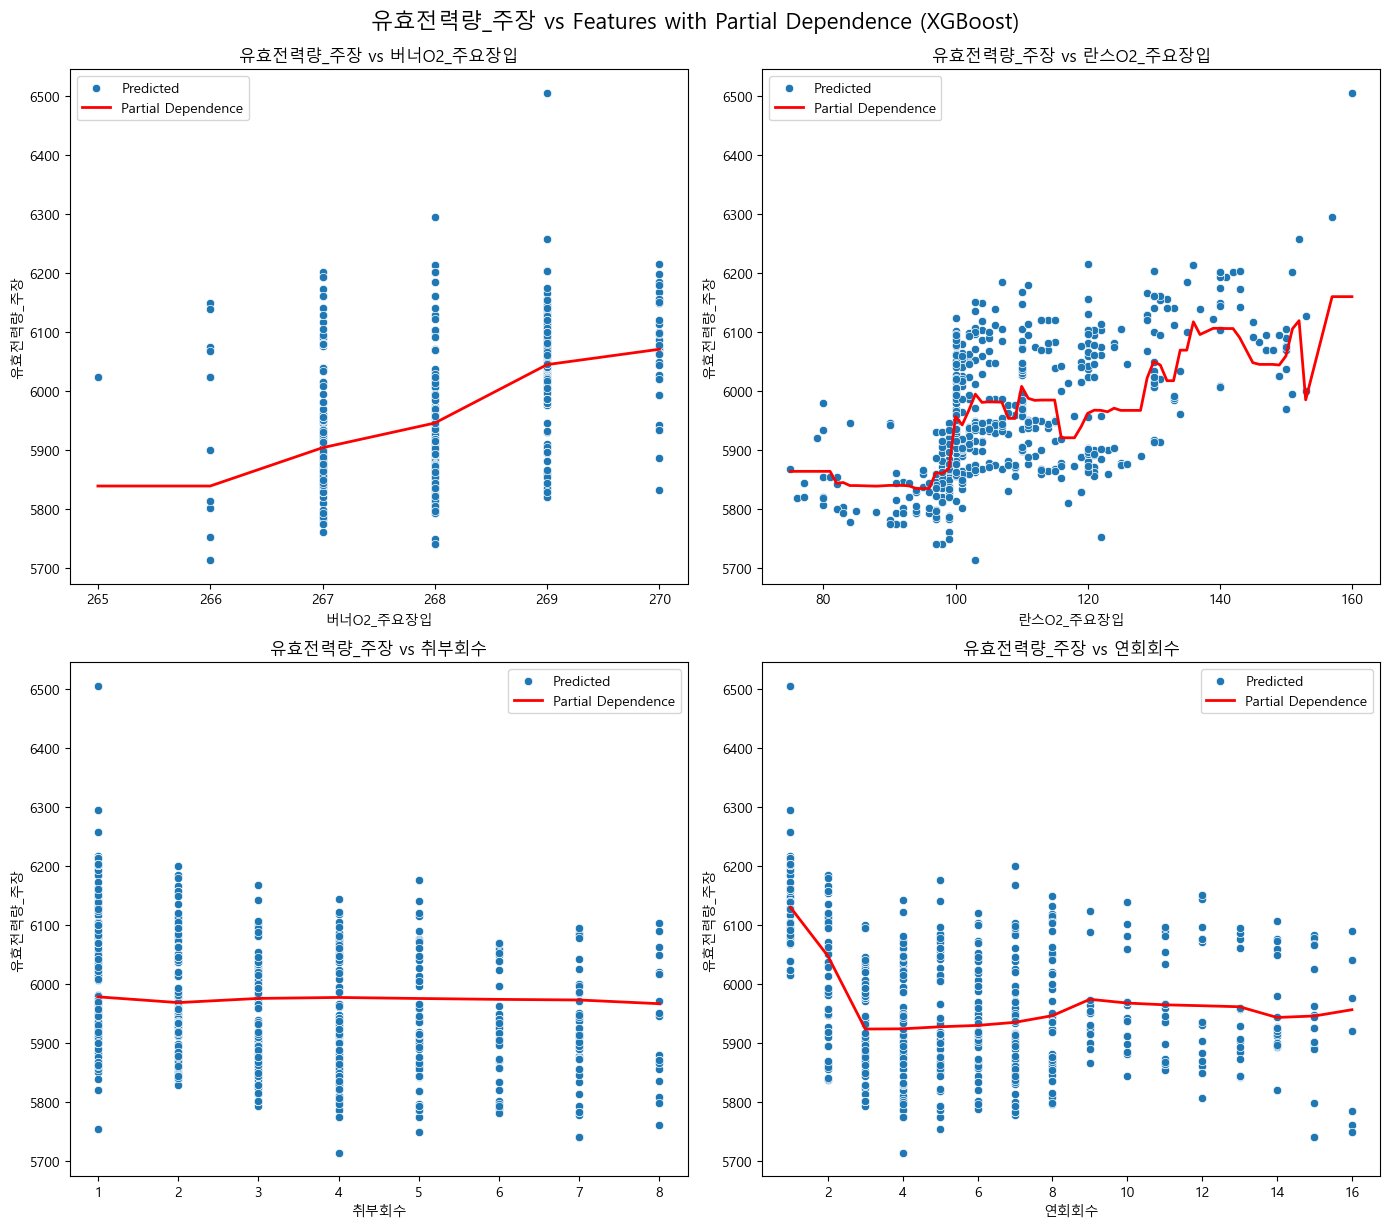

In [10]:
# Features to plot
features = [variable_1, variable_2, variable_3, variable_4]
n_features = len(features)

X_test = X_test.astype('float')

# Subplot Grid
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 12))
axes = axes.flatten()  # To index easily

# Plot the features
for i, feature in enumerate(features):
    ax = axes[i]
    feature_index = X_test.columns.get_loc(feature)

    # Partial dependence
    pd_result = partial_dependence(xgb_model, X_test, [feature_index], kind='average')
    x_vals = pd_result['grid_values'][0]
    y_vals = pd_result['average'][0]

    # Scatter: actual model predictions
    sns.scatterplot(
        x=X_test[feature],
        y=xgb_model.predict(X_test),
        alpha=1,
        ax=ax,
        label='Predicted'
    )

    # Partial dependence line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='Partial Dependence')

    # Format
    ax.set_xlabel(feature)
    ax.set_ylabel('유효전력량_주장')
    ax.set_title(f'유효전력량_주장 vs {feature}')
    ax.legend()

# Remove any unused subplots
if len(axes) > n_features:
    for j in range(n_features, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('유효전력량_주장 vs Features with Partial Dependence (XGBoost)', fontsize=16, y=1.02)
plt.show()

# Time Series Data

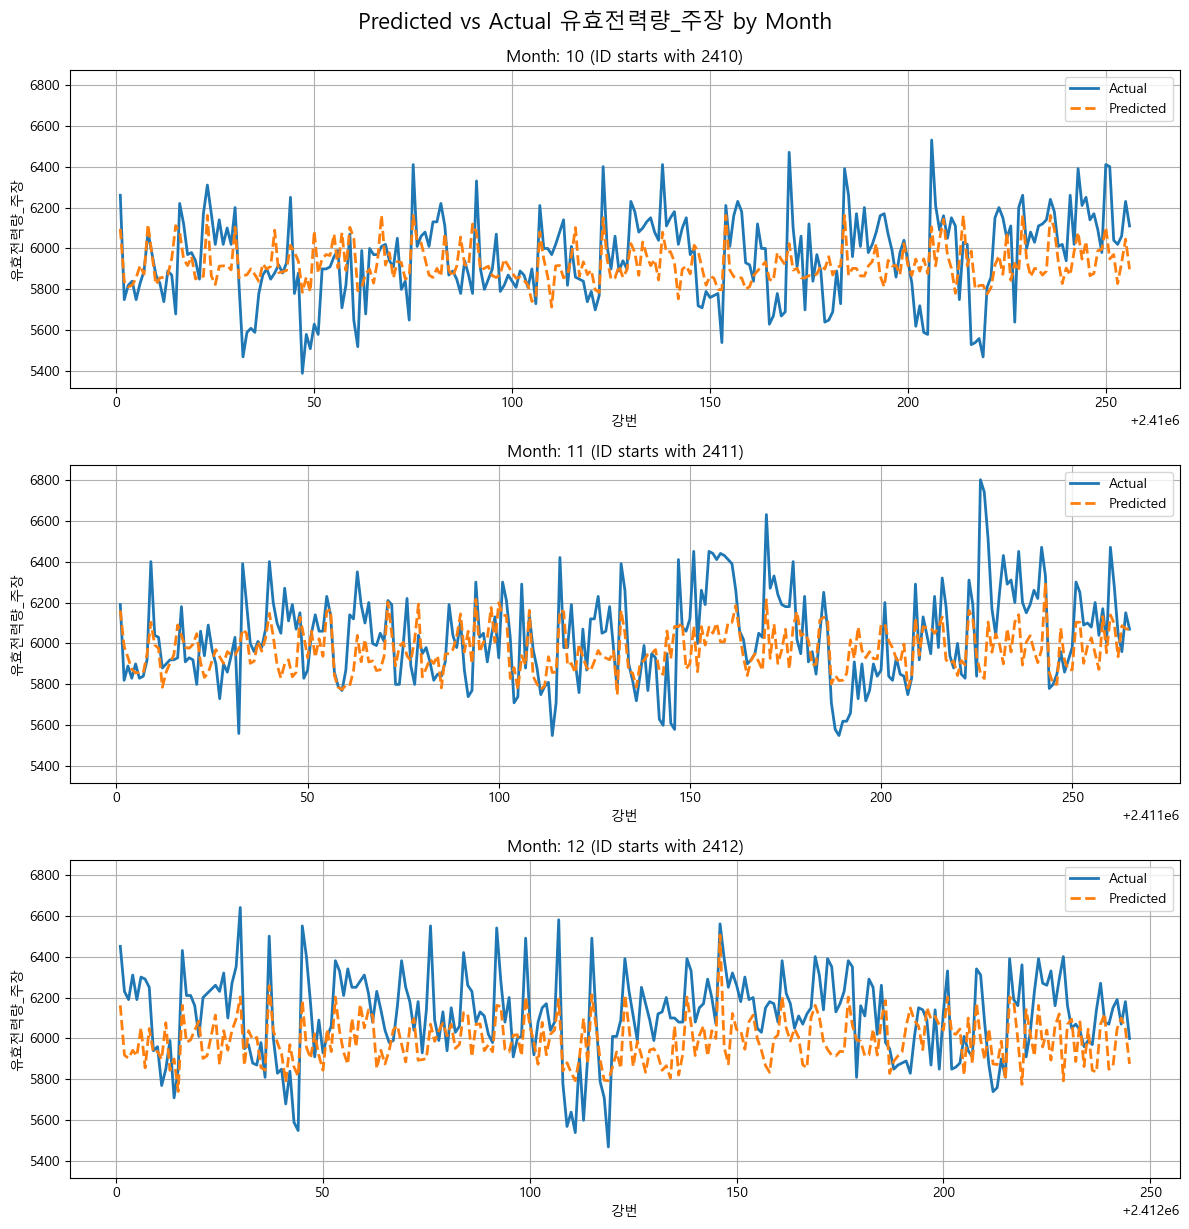

In [11]:
# Combine ID number, Actual power, and Predicted power into one DataFrame
id_aligned_df = df[['강번']].loc[X_test.index].copy()
id_aligned_df['Actual'] = y_test.values
id_aligned_df['Predicted'] = xgb_pred

# Sort by ID number for line plotting
id_aligned_df = id_aligned_df.sort_values('강번').reset_index(drop=True)

# Extract month from ID (e.g., 2401xxx → 1)
id_aligned_df['Month'] = id_aligned_df['강번'].astype(str).str[2:4].astype(int)
months = [10, 11, 12]

# Set up subplots
n_months = len(months)
fig, axes = plt.subplots(n_months, 1, figsize=(12, 4 * n_months), sharey=True)

if n_months == 1:
    axes = [axes]

for i, month in enumerate(months):
    ax = axes[i]
    month_df = id_aligned_df[id_aligned_df['Month'] == month].sort_values('강번')

    ax.plot(month_df['강번'], month_df['Actual'], label='Actual', linewidth=2)
    ax.plot(month_df['강번'], month_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    ax.set_title(f'Month: {month} (ID starts with 24{month:02d})')
    ax.set_xlabel('강번')
    ax.set_ylabel('유효전력량_주장')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Predicted vs Actual 유효전력량_주장 by Month', fontsize=16, y=1.02)
plt.show()

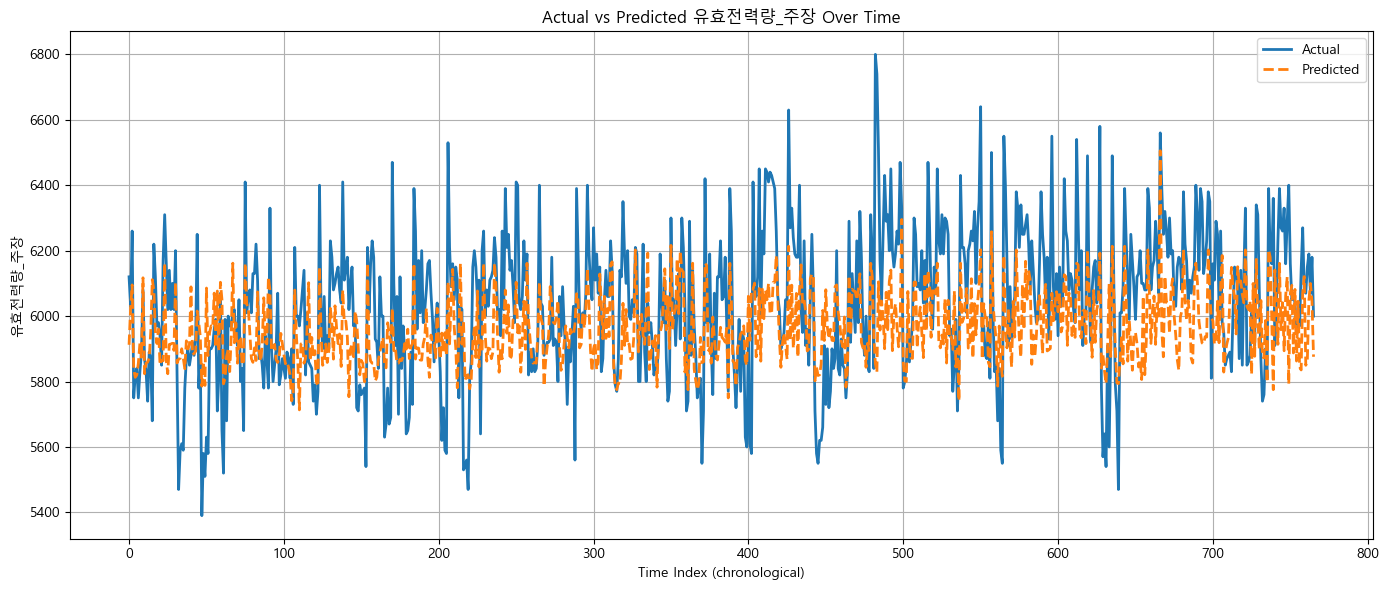

In [12]:
# Create a continuous time index
id_aligned_df['Time Index'] = range(len(id_aligned_df))

# Plot with continuous index
plt.figure(figsize=(14, 6))
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Actual'], label='Actual', linewidth=2)
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
plt.xlabel('Time Index (chronological)')
plt.ylabel('유효전력량_주장')
plt.title('Actual vs Predicted 유효전력량_주장 Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()